In [3]:
pip install yfinance numpy pandas matplotlib scikit-learn tensorflow


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam


In [5]:
# Load historical stock data
ticker = 'AAPL'  # Replace with your desired stock ticker
start_date = '2010-01-01'
end_date = '2024-01-01'

df = yf.download(ticker, start=start_date, end=end_date)

# Use the closing price as the target for prediction
df = df[['Close']]
df.head()


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714


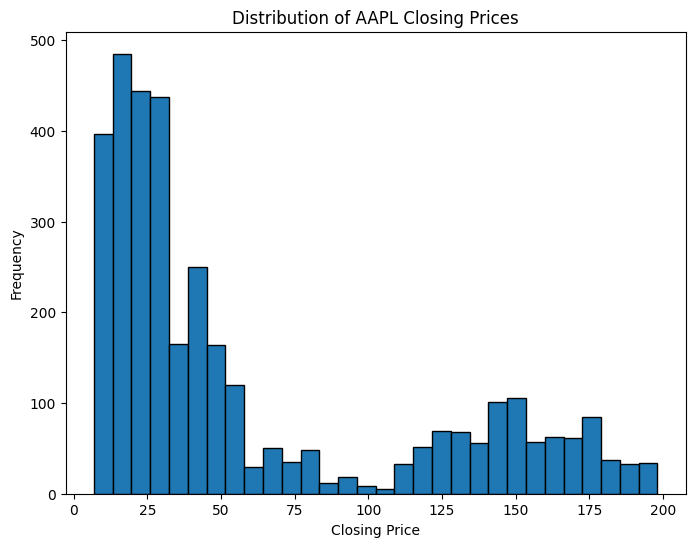

In [6]:
# distribution plot
# @title Distribution of AAPL Closing Prices

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(df['Close'], bins=30, edgecolor='black')
plt.title('Distribution of AAPL Closing Prices')
plt.xlabel('Closing Price')
_ = plt.ylabel('Frequency')

In [7]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# Create sequences of data to use as input
sequence_length = 100  # Use the last 60 days' prices to predict the next day's price

X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])  # Sequence of previous 'sequence_length' prices
    y.append(scaled_data[i, 0])  # Predict the next day's price

X = np.array(X)
y = np.array(y)

# Reshape data for RNN models (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [8]:
# Split the data into training (80%) and test (20%) sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [9]:
def build_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer=Adam(), loss='mean_squared_error')  # Compile the model
    return model


In [10]:
# Initialize the model
rnn_model = build_rnn_model()

# Train the model
rnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0206
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0839e-04
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8676e-04
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6983e-04
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2770e-04


In [11]:
# Make predictions using the trained RNN model
rnn_predictions = rnn_model.predict(X_test)

# Inverse scale the predictions and actual values to get real stock prices
rnn_predictions = scaler.inverse_transform(rnn_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE and MAE for the model
rnn_rmse = np.sqrt(mean_squared_error(y_test_actual, rnn_predictions))
rnn_mae = mean_absolute_error(y_test_actual, rnn_predictions)

print(f"RNN RMSE: {rnn_rmse}")
print(f"RNN MAE: {rnn_mae}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RNN RMSE: 7.752935107029499
RNN MAE: 6.275043816113994


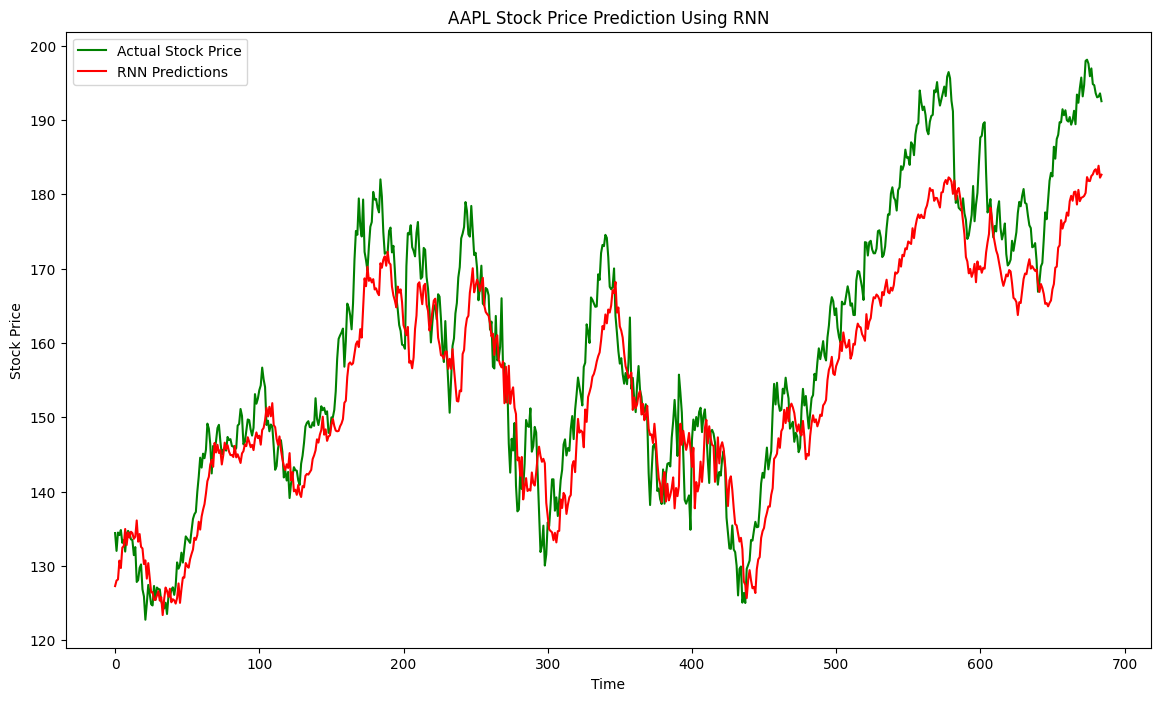

In [12]:
# Plot actual vs predicted stock prices
plt.figure(figsize=(14, 8))
plt.plot(y_test_actual, color='green', label='Actual Stock Price')
plt.plot(rnn_predictions, color='red', label='RNN Predictions')
plt.title(f"{ticker} Stock Price Prediction Using RNN")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [13]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.7 MB/s eta 0:00:00


In [ ]:
# now hyper parameter tuning:
import keras_tuner as kt

# Define a function to create the RNN model for hyperparameter tuning
def build_rnn_model(hp):
    model = Sequential()
    # Tune the number of units in the RNN layer
    model.add(SimpleRNN(units=hp.Int('units', min_value=50, max_value=200, step=50),
                         return_sequences=False,
                         input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))  # Output layer
    # Tune the learning rate of the Adam optimizer
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
                  loss='mean_squared_error')  # Compile the model
    return model


In [ ]:
# Initialize the tuner
tuner = kt.Hyperband(build_rnn_model,
                     objective='val_loss',  # Minimize the validation loss
                     max_epochs=10,  # Maximum number of epochs
                     hyperband_iterations=2,  # Number of different configurations to try
                     directory='hyperparameter_tuning',
                     project_name='rnn_stock_prediction')

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Get the best model's hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hyperparameters.values)


Reloading Tuner from hyperparameter_tuning/rnn_stock_prediction/tuner0.json
Best Hyperparameters: {'units': 150, 'learning_rate': 0.004591032097322839, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


In [ ]:
# Build the model with the best hyperparameters
best_rnn_model = tuner.hypermodel.build(best_hyperparameters)

# Train the model with the optimal hyperparameters
best_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.4331 - val_loss: 0.0746
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0045 - val_loss: 0.0218
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0371 - val_loss: 0.2759
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0895 - val_loss: 0.3059
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0744 - val_loss: 2.5388
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2872 - val_loss: 0.3691
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0217 - val_loss: 0.4721
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0197 - val_loss: 0.3890
Epoch 9/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0183 - val_loss: 0.3668
Epoch 10/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0160 - val_loss: 0.3151
Epoch 11/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0132 - val_loss: 0.2781
Epoch 12/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0114 - val_l

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Root Mean Squared Error (RMSE): 3.0440949037590284
Mean Absolute Error (MAE): 2.3572584277521953


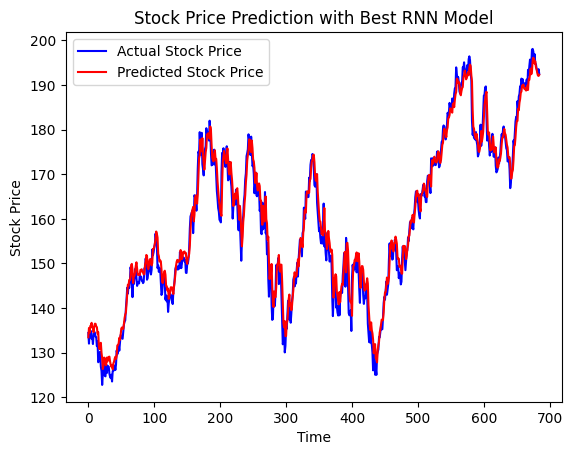

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming 'best_model' is the model returned by the tuner
# and X_test, y_test are your test features and true values respectively.

# Step 1: Make predictions on the test set
predictions = best_model.predict(X_test)

# Step 2: Rescale the predictions and actual values to the original scale (back to the stock price scale)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 3: Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Step 4: Calculate MAE
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
print(f"Mean Absolute Error (MAE): {mae}")

# Optional: Plot the predicted vs actual values for visualization
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Stock Price')
plt.plot(predictions_rescaled, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction with Best RNN Model')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_lstm_model(hp):
    model = Sequential()

    # Hyperparameter tuning for LSTM layer
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                   activation='tanh',
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True))  # Return sequences for stacking LSTM layers

    # Dropout layer to prevent overfitting
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Additional LSTM layer
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                   activation='tanh', return_sequences=False))  # No need to return sequences

    # Dropout after second LSTM layer
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))  # Single output for stock price prediction

    # Optimizer with a learning rate parameter
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
                  loss='mean_squared_error')  # MSE for regression tasks

    return model


In [15]:
from keras_tuner import Hyperband

# Define the tuner
tuner = Hyperband(
    build_lstm_model,
    objective='val_loss',
    max_epochs=10,  # You can increase this based on your dataset size
    hyperband_iterations=2,
    directory='lstm_tuning',
    project_name='stock_prediction'
)

# Start the search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get the best model from the search
best_model = tuner.get_best_models(num_models=1)[0]


Trial 60 Complete [00h 00m 12s]
val_loss: 0.0006865742616355419

Best val_loss So Far: 0.0004197021771688014
Total elapsed time: 00h 06m 59s


In [20]:
# Get the best model's hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hyperparameters.values)


Best Hyperparameters: {'units': 150, 'dropout': 0.2, 'learning_rate': 0.0023967981706874255, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0043'}


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Root Mean Squared Error (RMSE): 4.057588771943338
Mean Absolute Error (MAE): 3.2267508959248117


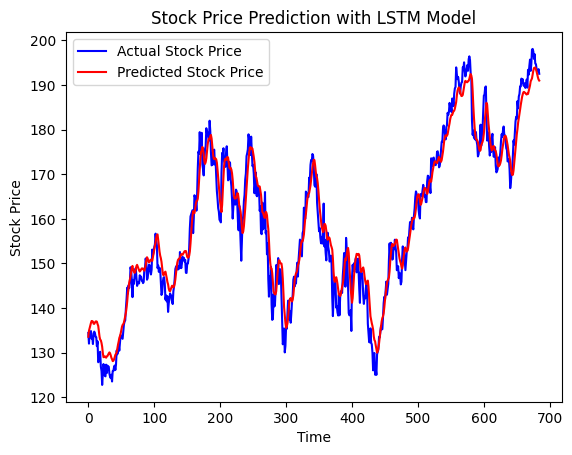

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Make predictions
predictions = best_model.predict(X_test)

# Rescale predictions and actual values back to the original stock price scale
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
print(f"Mean Absolute Error (MAE): {mae}")

# Optionally, plot predicted vs actual stock prices
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Stock Price')
plt.plot(predictions_rescaled, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction with LSTM Model')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
# feature engineering then the application to the best model
import pandas as pd

# Assuming `df` is your DataFrame containing stock price data (with 'Close' column)

# Simple Moving Average (SMA)
df['SMA_14'] = df['Close'].rolling(window=14).mean()

# Exponential Moving Average (EMA)
df['EMA_14'] = df['Close'].ewm(span=14, adjust=False).mean()

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Adding additional lag features (e.g., past 1, 2, 3 days)
df['Lag_1'] = df['Close'].shift(1)
df['Lag_2'] = df['Close'].shift(2)
df['Lag_3'] = df['Close'].shift(3)

# Drop any rows with NaN values (due to rolling windows)
df = df.dropna()

# Preview the DataFrame with new features
df.head()


Price,Close,SMA_14,EMA_14,RSI,Lag_1,Lag_2,Lag_3
Ticker,AAPL,,,,,,
Date,,,,,,,
2010-01-22,7.062500,7.495791,7.470993,31.472206,7.431071,7.561786,7.680000
2010-01-25,7.252500,7.467883,7.441861,38.882121,7.062500,7.431071,7.561786
2010-01-26,7.355000,7.446352,7.430279,41.837519,7.252500,7.062500,7.431071
2010-01-27,7.424286,7.438469,7.429480,46.924146,7.355000,7.252500,7.062500
2010-01-28,7.117500,7.409668,7.387883,40.338875,7.424286,7.355000,7.252500


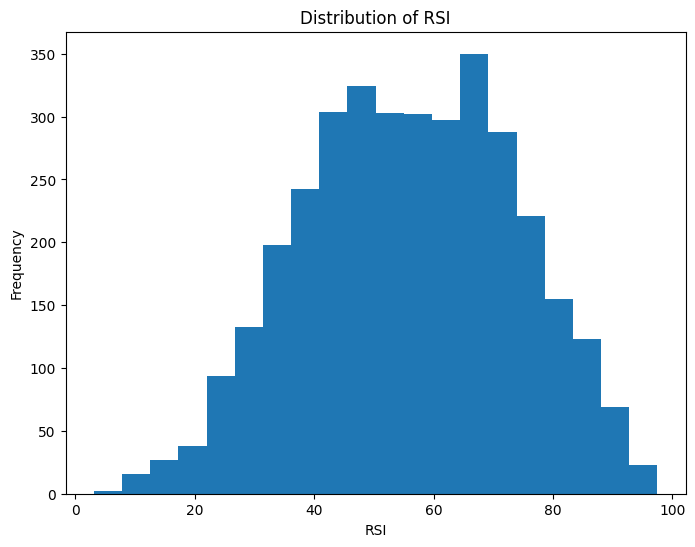

In [ ]:
# @title Distribution of RSI

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(df['RSI'], bins=20)
plt.title('Distribution of RSI')
plt.xlabel('RSI')
_ = plt.ylabel('Frequency')


In [ ]:
# reprocess the data:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Select features for model input
features = ['Close', 'SMA_14', 'EMA_14', 'RSI', 'Lag_1', 'Lag_2', 'Lag_3']

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    labels = []

    for i in range(sequence_length, len(data)):
        sequences.append(data[i-sequence_length:i])
        labels.append(data[i, 0])  # Assuming 'Close' is the target variable

    return np.array(sequences), np.array(labels)

sequence_length = 60  # Using past 60 days to predict the next day's price
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
# Retrain the best LSTM model on the new data
best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0030 - val_loss: 0.1877
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0153 - val_loss: 0.1547
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2049e-04 - val_loss: 0.1464
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1226e-04 - val_loss: 0.1282
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.4414e-04 - val_loss: 0.2208
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3053e-04 - val_loss: 0.1773
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1785e-04 - val_loss: 0.1339
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5319e-04 - val_loss: 0.1538
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3912e-04 - val_loss: 0.0497
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1009e-04 - val_loss: 0.1614


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Root Mean Squared Error (RMSE): 7.368573172009588
Mean Absolute Error (MAE): 5.887476228186458


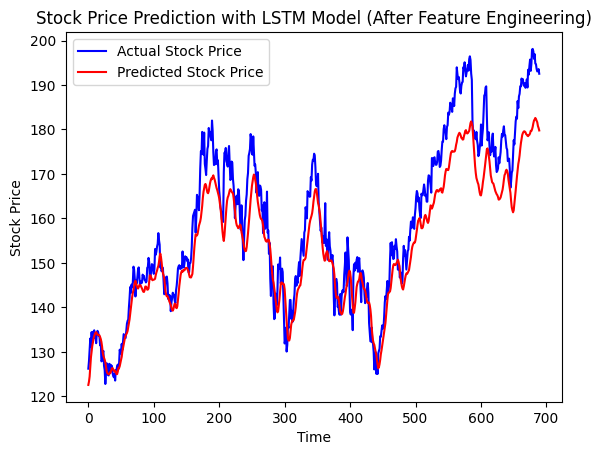

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Make predictions
predictions = best_model.predict(X_test)

# Rescale predictions and actual values back to the original stock price scale
predictions_rescaled = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], X_test.shape[2] - 1))), axis=1))[:,0]
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:,0]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
print(f"Mean Absolute Error (MAE): {mae}")

# Plot predicted vs actual stock prices
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Stock Price')
plt.plot(predictions_rescaled, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction with LSTM Model (After Feature Engineering)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
